In [15]:
# import torch
import torch, tqdm
import torch.nn as nn
import torchvision.models as models

from torchvision.models.vision_transformer import Encoder, EncoderBlock
from utils.data_utils import save_inp_oup_data, _get_train_samples, evaluate, GetDataset
from utils.quant_ViT import QuantViT

import matplotlib.pyplot as plt

In [16]:
# prepare the model
model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
model.eval().to("cuda")

# model = QuantViT(model)
model.eval().to("cuda")

_batch_size = 128

train_loader, test_loader = GetDataset(batch_size=_batch_size)

num_samples = 1 * _batch_size

cali_data = _get_train_samples(train_loader, num_samples)

saver = dict()


def save_name_input_output_hook(module, input, output, module_name):

    global saver
    
    saver[module_name] = (input[0], output)
    
    print(module_name, "saved !", )


""" ViT """
for name, module in model.named_children():
    """ Encoder """
    if isinstance(module, Encoder):
        for encoderBlocksNum, encoderBlocks in module.named_children():
            """ EncoderBlocks """
            if isinstance(encoderBlocks, nn.Sequential):  # 12 EncoderBlock
                for bname, block in encoderBlocks.named_children():
                    """ each EncoderBlock """
                    if isinstance(block, EncoderBlock):
                        for layerName, layerModule in block.named_children():
                            """ inside of EncoderBlock """
                            if layerName == "dropout":
                                continue

                            layerModule.register_forward_hook(
                                lambda mod, inp, out, layerName=layerName: save_name_input_output_hook(
                                    mod, inp, out, layerName
                                )
                            )
                            print(layerName, "hooked !")
                        break
            
                    

    if isinstance(module, nn.Linear):
        module.register_forward_hook(
            lambda mod, inp, out, layerName="Linear": save_name_input_output_hook(
                mod, inp, out, layerName
            )
        )
        print("Linear hooked !")
model(cali_data.to("cuda"))

print("")

ln_1 hooked !
self_attention hooked !
ln_2 hooked !
mlp hooked !
ln_1 saved !
self_attention saved !
ln_2 saved !
mlp saved !



In [17]:
saver.keys()

dict_keys(['ln_1', 'self_attention', 'ln_2', 'mlp'])

In [18]:
for key, value in saver.items():
    print(key, type(key), type(value))
    _input, _output = value
    print(type(_input), type(_output))
    if type(_input) == tuple:
        print("input", key, [i.shape for i in _input])
    else:
        print("input", key, _input.shape)
    if type(_output) == tuple:
        for i in _output:
            print("output", key, type(i))
    else:
        print("output", key, _output.shape)
    print("")

ln_1 <class 'str'> <class 'tuple'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
input ln_1 torch.Size([128, 197, 768])
output ln_1 torch.Size([128, 197, 768])

self_attention <class 'str'> <class 'tuple'>
<class 'torch.Tensor'> <class 'tuple'>
input self_attention torch.Size([128, 197, 768])
output self_attention <class 'torch.Tensor'>
output self_attention <class 'torch.Tensor'>

ln_2 <class 'str'> <class 'tuple'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
input ln_2 torch.Size([128, 197, 768])
output ln_2 torch.Size([128, 197, 768])

mlp <class 'str'> <class 'tuple'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
input mlp torch.Size([128, 197, 768])
output mlp torch.Size([128, 197, 768])



In [19]:
def plot_data(input, output, title: str):

    inshape = input.shape
    outshape = output.shape

    input = input.cpu().detach().numpy().flatten()
    output = output.cpu().detach().numpy().flatten()

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    ax[0].hist(input, bins=100, alpha=0.5, label="Input")
    ax[1].hist(output, bins=1000, alpha=0.5, label="Output")
    ax[0].set_yscale("log")
    ax[1].set_yscale("log")
    if title == "attn_map":
        # ax[0].set_xscale("log")
        ax[1].set_xscale("log")
        ax[1].set_xlim(1e-5, 1)
        # ax[0].set_yscale("linear")
        # ax[1].set_yscale("linear")
    _titlestr = f"{title} \n input.shape: {inshape}, output.shape: {outshape}"
    fig.suptitle(_titlestr)

    plt.show()

    if title in ["self_attention", "mlp"]:
        print("residual addition")

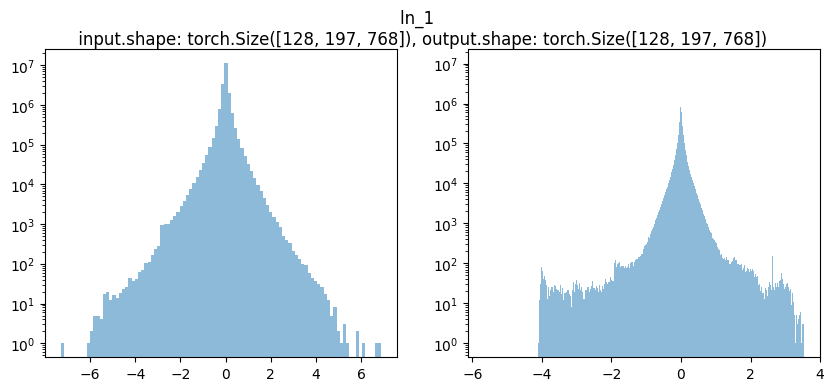

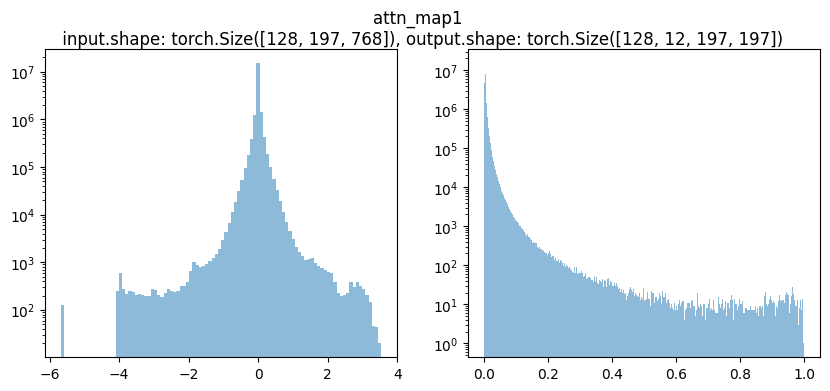

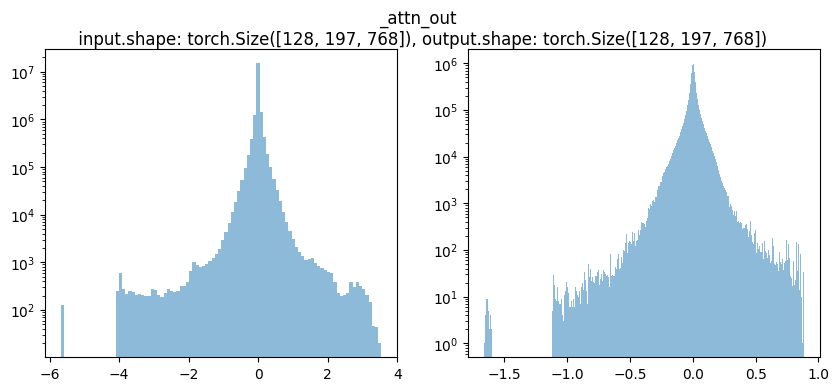

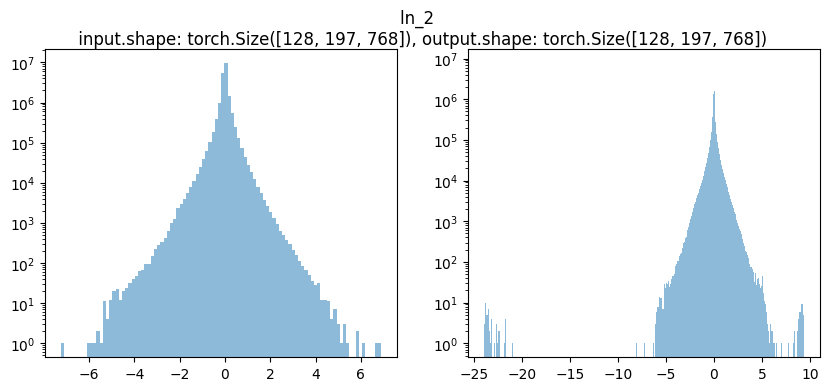

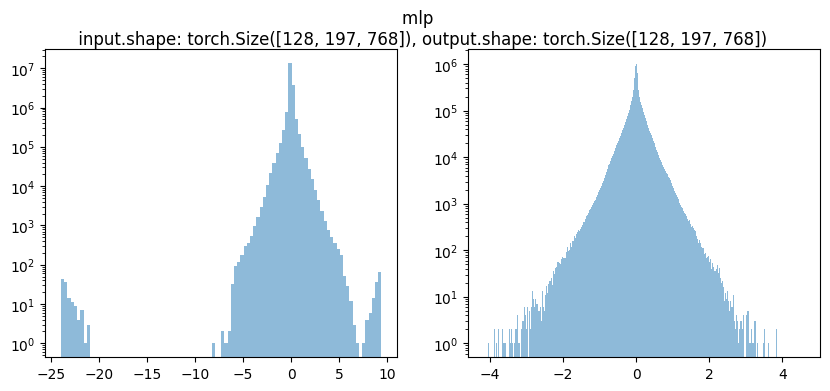

residual addition


In [20]:
for key, value in saver.items():
    _input, _output = value

    if key == "self_attention":
        _attn_out, _attn_map = _output
        if _attn_map != None:
            plot_data(_input, _attn_map, "attn_map1")
        plot_data(_input, _attn_out, "_attn_out")
    else:
        plot_data(_input, _output, key)

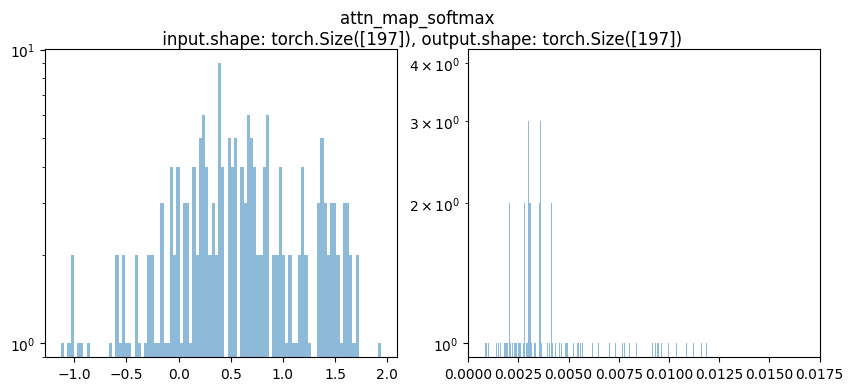

tensor(1., device='cuda:0')


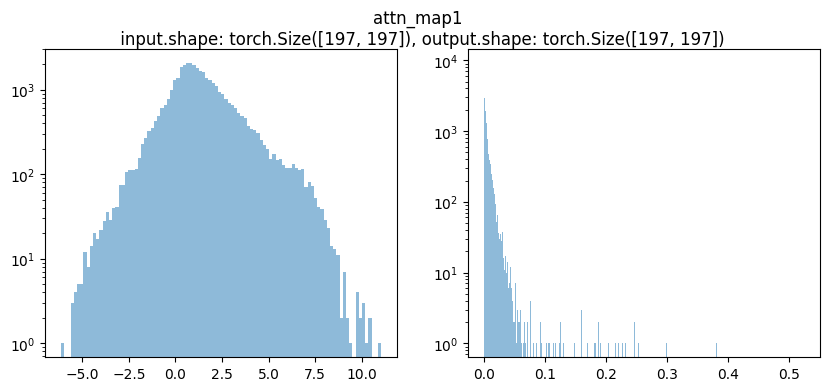

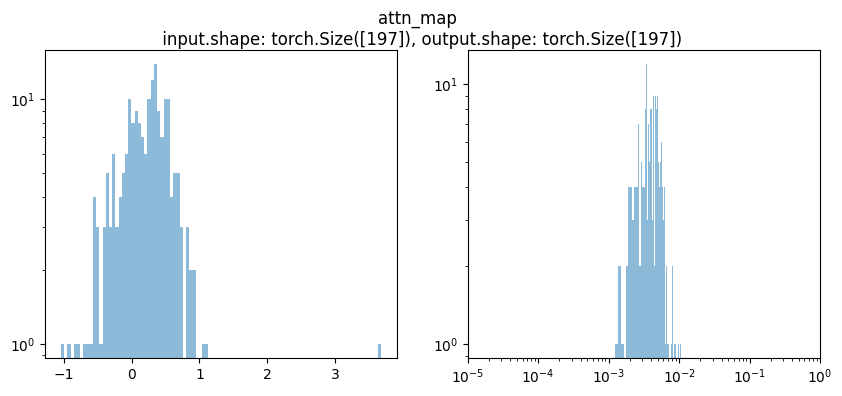

In [38]:
attn_map_qk = torch.load("attn_map_qk.pt")
attn_map_softmax = torch.load("attn_map_softmax.pt")

plot_data(attn_map_qk[0, 0, 0, :], attn_map_softmax[0, 0, 0, :], "attn_map_softmax")
print(attn_map_softmax[0, 0, 0, :].sum())

plot_data(attn_map_qk[0, 0, :, :], attn_map_softmax[0, 0, :, :], "attn_map1")
plot_data(attn_map_qk[0, 1, 1, :], attn_map_softmax[0, 1, 1, :], "attn_map")
# plot_data(attn_map_qk[10, 0, :, :], attn_map_softmax[10, 0, :, :], "attn_map_softmax")

In [22]:
attn_map_softmax[0, 0, :, :].sum()

tensor(197., device='cuda:0')

In [36]:
attn_map_qk.max()


tensor(26.8381, device='cuda:0')